In [1]:
import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
from time import time
import os
import torch
from torch_geometric.data import InMemoryDataset, Data
from collections import defaultdict
import episcanpy.api as epi
import scanpy as sc
import numpy as np
import pandas as pd
from pandas import DataFrame
import anndata as ad
from anndata import AnnData
from typing import Optional, Mapping, List, Union
from scipy import sparse
import sklearn
from statsmodels.distributions.empirical_distribution import ECDF
import pickle
import random
import cosg


In [2]:
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)
    
graph = ATACGraphDataset('./input_graph/')

In [3]:
import pandas as pd
import numpy as np

test_cell = pd.read_csv('./test_barcode.txt', header=None)[0].values

In [4]:
# test_cell = sampled_indices
dataset_graph = graph

In [5]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm


data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 
train_graph = []
test_graph = []
test_cell_type = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):
    sample.id_vec = torch_vector
    sample.seq_data = 1
    if sample.cell in test_cell:
        test_graph.append(sample)
        test_cell_type.append(sample.y.item())
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y.item())

Processing samples: 100%|██████████| 2130/2130 [00:00<00:00, 3433.98it/s]


In [6]:
from collections import Counter
from tqdm import tqdm

# 计算每个类别的样本数量
class_counts = Counter(train_cell_type)

# 找到最多的类别样本数
max_count = max(class_counts.values())

# 复制样本以实现类别平衡
balanced_train_graph = []

for cell_type, count in class_counts.items():
    # 找到对应的样本
    samples = [sample for sample in train_graph if sample.y.item() == cell_type]

    # 计算需要复制的样本数量
    samples_to_add = max_count - count

    # 复制样本并添加到平衡后的训练图中
    balanced_train_graph.extend(samples)
    balanced_train_graph.extend(random.choices(samples, k=samples_to_add))

# 现在 balanced_train_graph 包含类别平衡的训练样本


In [7]:
import torch
import torch.nn as nn

class EdgeDiversityLoss1(nn.Module):
    def __init__(self, diversity_weight=1.0):
        """
        自定义多样性损失函数
        :param diversity_weight: 控制熵惩罚的权重
        """
        super(EdgeDiversityLoss1, self).__init__()
        self.diversity_weight = diversity_weight

    def forward(self, edge_weights):
        prob_distribution = torch.softmax(edge_weights, dim=0)
        entropy_loss = -self.diversity_weight * torch.sum(prob_distribution * torch.log(prob_distribution + 1e-6), dim=0)
        
        # 添加均匀性损失
        target_distribution = torch.full_like(prob_distribution, 1.0 / edge_weights.numel())
        uniformity_loss = torch.sum((prob_distribution - target_distribution) ** 2)

        # 总损失
        loss = torch.sum(entropy_loss) + uniformity_loss
        return loss

class EdgeDiversityLoss2(nn.Module):
    def __init__(self, non_zero_penalty_weight=1.0):
        """
        自定义多样性损失函数
        :param non_zero_penalty_weight: 控制非零惩罚的权重
        """
        super(EdgeDiversityLoss2, self).__init__()
        self.non_zero_penalty_weight = non_zero_penalty_weight

    def forward(self, edge_weights):
        """
        计算自定义多样性损失
        :param edge_weights: 模型生成的边权重矩阵 (torch.Tensor)，形状为 (batch_size, num_edges)
        :return: 计算出的多样性损失 (torch.Tensor)
        """
        # 筛选出非零元素
        non_zero_weights = edge_weights[edge_weights != 0]

        # 计算非零元素的方差并取负
        variance_loss = -torch.var(non_zero_weights)

        # 计算非零惩罚：惩罚零权重的数量
        non_zero_penalty = self.non_zero_penalty_weight * torch.sum((edge_weights == 0).float())

        # 总损失：使用负方差作为多样性损失和非零惩罚的组合
        loss = variance_loss + non_zero_penalty
        return loss

In [8]:
graph[0], len(np.unique(dataset_atac.array_celltype))

(Data(x=[56044, 1], edge_index=[2, 65638], y=[1], edge_tf=[1577, 2], y_exp=[1530], cell='TCCATACCAATGATGCGGCATTCT'),
 6)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=1,
                 node_output_dim=8,
                 edge_embedding_dim=8,
                 hidden_channels=16,  # 增加 hidden_channels
                 gat_input_channels=8,
                 gat_hidden_channels=8,  # 增加 GAT 隐藏通道
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.2,  # 增加 dropout
                 num_head_1=16,  # 增加 GAT 头数
                 num_head_2=16):  # 增加 GAT 头数
        super(SCReGAT, self).__init__()

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(3, 16),
            nn.LayerNorm(16),
            nn.LeakyReLU(),
            nn.Linear(16, edge_embedding_dim),
            nn.LeakyReLU()
        )

        # GAT layers with increased heads and self-loops
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(0.1)  
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        
        self.NN_cell_type = nn.Sequential(
            nn.Linear(1530, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 6),
            nn.Softmax()
        )
        

    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num, gene_id_vec, is_test=False):
        data = raw_x
        p_batch = batch.unique()
        data = self.NN_node(data)
        hidden_edge_input = torch.cat((raw_x[edge_index[0]] * raw_x[edge_index[1]], raw_x[edge_index[0]], raw_x[edge_index[1]]), dim=1)
        self.data = data
        hidden_edge = self.NN_edge(hidden_edge_input).tanh()
        self.model_edge = hidden_edge
        model.edge = torch.median(hidden_edge, dim=1)[0]
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))
        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        data = data_1 + data_2
        self.data = data
        if is_test == False:
            cell_list = []
            for t in p_batch:
                cell_list.append(data[(batch == t) & (gene_id_vec == 1)])
            temp = torch.mean(torch.stack(cell_list), dim=2)
            cell_type = self.NN_cell_type(temp)
        else:
            cell_type = None
            pass
        gene_out = -F.log_softmax(data[gene_id_vec==1], dim=1)[:, 0]
        return gene_out, atten_w1, cell_type

import torch
import torch.nn as nn

In [11]:
model = SCReGAT()
train_graph = balanced_train_graph

In [12]:
import torch

# 检查GPU是否可用
if torch.cuda.is_available():
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")


GPU is available
Device name: GeForce RTX 3090


In [13]:
import torch
import random
from tqdm import tqdm

gene_num = len(sample.y_exp)
device = 'cuda:0'
model.to(device)
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
# loss_exp = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 10
attention_reg_weight = 0.000001
sparse_loss_weight = 0.0001
info_weight = 0.01
batch_size = 16
criterion_sparse1 = EdgeDiversityLoss1(diversity_weight=1.0)
criterion_sparse2 = EdgeDiversityLoss2(non_zero_penalty_weight=1.0)
criterion2 = torch.nn.CrossEntropyLoss()
max_grad_norm = 1.0


In [16]:
def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]


for epoch in range(num_epoch):
    train_loader = DataLoader(train_graph, batch_size=batch_size, shuffle=True)
    model.train()
    running_loss = 0.0
    running_loss1 = 0.0
    running_attention_loss = 0.0  # 记录 attention 正则化损失
    running_sparse_loss = 0.0  # 记录稀疏损失
    running_cell_loss = 0.0  # 记录 loss_cell

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")
    
    for idx, sample in enumerate(progress_bar):
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()
        edge_index_dropped = sample.edge_index
        gene_pre, atten, cell_pre = model(
            sample.seq_data.to(device),
            sample.x.to(device),
            sample.edge_index.to(device),
            sample.edge_tf.T.to(device),
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device)
        )
        edge_temp = model.edge
        labels = sample.y.to(device)
        index = torch.where(sample.x[sample.id_vec == 1] > 0)[0]
        loss1 = -loss_exp(gene_pre.flatten()[index], sample.y_exp.to(device)[index]) 
        loss_cell = criterion2(cell_pre, labels)
        temp_var_edge = torch.stack(torch.split(edge_temp, sample.edge_index.shape[1] // len(sample.y)))
        temp_var_atten = torch.stack(torch.split(atten[1], sample.edge_index.shape[1] // len(sample.y)))
        attention_loss = attention_reg_weight * criterion_sparse2(temp_var_atten)
        # loss_infonce = info_weight * infonce_loss(temp_var_edge, labels, temperature=0.1)  # InfoNCE loss

        loss2 = sparse_loss_weight * criterion_sparse1(temp_var_edge)
        
        loss = loss1 + attention_loss + loss2 + loss_cell 
  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        running_loss += loss.item()
        running_loss1 += loss1.item()
        running_attention_loss += attention_loss.item()  # 记录注意力正则化损失
        running_sparse_loss += loss2.item()  # 记录稀疏损失
        running_cell_loss += loss_cell.item()  # 记录 loss_cell
     
        
        if idx % 200 == 0:
            print(gene_pre, edge_temp, atten)
            print(f"gene_pre: {gene_pre}, loss_cell: {loss_cell.item()}, attention_loss: {attention_loss.item()}, sparse_loss: {loss2.item()}")
        
        progress_bar.set_postfix(
            loss=running_loss / (progress_bar.n + 1),
            loss1=running_loss1 / (progress_bar.n + 1),
            attention_loss=running_attention_loss / (progress_bar.n + 1),
            sparse_loss=running_sparse_loss / (progress_bar.n + 1),
            cell_loss=running_cell_loss / (progress_bar.n + 1)
        )
        
        torch.cuda.empty_cache()
    
    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}, "
          f"Loss1: {running_loss1 / len(train_loader):.4f}, Attention Loss: {running_attention_loss / len(train_loader):.4f}, "
          f"Sparse Loss: {running_sparse_loss / len(train_loader):.4f}, Cell Loss: {running_cell_loss / len(train_loader):.4f}")


Epoch 1/10:   0%|          | 1/207 [00:00<00:51,  3.97batch/s, attention_loss=3.36, cell_loss=1.79, loss=7.02, loss1=0.00762, sparse_loss=1.86]

tensor([2.8074, 2.8113, 2.8116,  ..., 2.8118, 2.8121, 2.8098], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([-0.0022, -0.0025, -0.0025,  ..., -0.0025, -0.0025, -0.0012],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0000, 0.0219, 0.0215,  ..., 0.0218, 0.0226, 0.0218],
        [0.0405, 0.0391, 0.0389,  ..., 0.0405, 0.0378, 0.0000],
        [0.0405, 0.0391, 0.0389,  ..., 0.0405, 0.0000, 0.0000],
        ...,
        [0.0313, 0.0305, 0.0304,  ..., 0.0313, 0.0297, 0.0000],
        [0.0761, 0.0736, 0.0733,  ..., 0.0761, 0.0000, 0.0733],
        [0.0686, 0.0734, 0.0737,  ..., 0.0703, 0.0773, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.8074, 2.8113, 2.8116,  ..., 2.8118, 2.8121, 2.8098], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.7932230234146118, atte

Epoch 1/10:  97%|█████████▋| 201/207 [00:57<00:01,  3.56batch/s, attention_loss=3.36, cell_loss=1.19, loss=6.4, loss1=0.00792, sparse_loss=1.85] 

tensor([2.7738, 2.7741, 2.7747,  ..., 2.7745, 2.7744, 2.7741], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([-8.7324e-03, -6.2010e-03, -5.7487e-03,  ..., -4.2085e-05,
         1.1203e-01, -7.9115e-04], device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0224, 0.0381, 0.0232,  ..., 0.0343, 0.0000, 0.0313],
        [0.0393, 0.0000, 0.0394,  ..., 0.0000, 0.0394, 0.0398],
        [0.0379, 0.0114, 0.0000,  ..., 0.0191, 0.0230, 0.0208],
        ...,
        [0.0230, 0.0197, 0.0218,  ..., 0.0238, 0.0162, 0.0279],
        [0.0825, 0.1266, 0.0918,  ..., 0.0000, 0.0000, 0.0000],
        [0.0684, 0.0471, 0.0000,  ..., 0.0559, 0.0576, 0.0666]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.7738, 2.7741, 2.7747,  ..., 2.7745, 2.7744, 2.7741], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell:

Epoch 1/10: 100%|██████████| 207/207 [00:58<00:00,  3.53batch/s, attention_loss=3.35, cell_loss=1.18, loss=6.39, loss1=0.00792, sparse_loss=1.85]


Epoch [1/10], Average Loss: 6.3924, Loss1: 0.0079, Attention Loss: 3.3545, Sparse Loss: 1.8463, Cell Loss: 1.1837, InfoNCE Loss: 0.0000


Epoch 2/10:   0%|          | 1/207 [00:00<00:56,  3.68batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.25, loss1=0.00755, sparse_loss=1.83]

tensor([2.7743, 2.7741, 2.7753,  ..., 2.7745, 2.7746, 2.7747], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([-0.0067, -0.0070, -0.0075,  ..., -0.0043,  0.9637,  0.9513],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0000, 0.0432, 0.0236,  ..., 0.0366, 0.0322, 0.0339],
        [0.0402, 0.0759, 0.0420,  ..., 0.0000, 0.0560, 0.0595],
        [0.0000, 0.0785, 0.0419,  ..., 0.0678, 0.0551, 0.0602],
        ...,
        [0.0298, 0.0116, 0.0285,  ..., 0.0171, 0.0201, 0.0000],
        [0.0944, 0.1284, 0.0000,  ..., 0.1098, 0.1259, 0.0822],
        [0.0857, 0.0609, 0.0711,  ..., 0.0646, 0.0750, 0.0739]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.7743, 2.7741, 2.7753,  ..., 2.7745, 2.7746, 2.7747], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.050239086151123, atten

Epoch 2/10:  97%|█████████▋| 201/207 [00:55<00:01,  3.34batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.24, loss1=0.00787, sparse_loss=1.82]

tensor([2.7707, 2.7709, 2.7718,  ..., 2.4789, 2.5034, 2.5275], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([ 0.9925,  0.9842,  0.9964,  ..., -0.0017,  0.9968, -0.0017],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0231, 0.0498, 0.0240,  ..., 0.0394, 0.0000, 0.0371],
        [0.0366, 0.0247, 0.0000,  ..., 0.0312, 0.0282, 0.0358],
        [0.0419, 0.0409, 0.0385,  ..., 0.0357, 0.0457, 0.0396],
        ...,
        [0.0000, 0.0274, 0.0265,  ..., 0.0277, 0.0244, 0.0292],
        [0.0000, 0.0912, 0.0000,  ..., 0.0896, 0.1421, 0.0881],
        [0.0674, 0.0686, 0.0000,  ..., 0.0000, 0.0627, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.7707, 2.7709, 2.7718,  ..., 2.4789, 2.5034, 2.5275], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.0460073947906494, atte

Epoch 2/10: 100%|██████████| 207/207 [00:56<00:00,  3.65batch/s, attention_loss=3.35, cell_loss=1.05, loss=6.23, loss1=0.00786, sparse_loss=1.81]


Epoch [2/10], Average Loss: 6.2274, Loss1: 0.0079, Attention Loss: 3.3546, Sparse Loss: 1.8145, Cell Loss: 1.0505, InfoNCE Loss: 0.0000


Epoch 3/10:   0%|          | 1/207 [00:00<00:58,  3.53batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.22, loss1=0.00762, sparse_loss=1.81]

tensor([2.7706, 2.5036, 2.7705,  ..., 2.7701, 2.7711, 2.7719], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([ 0.9934, -0.0018, -0.0018,  ...,  0.9845,  0.9968,  0.9951],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0231, 0.0528, 0.0242,  ..., 0.0412, 0.0000, 0.0405],
        [0.0290, 0.0328, 0.0313,  ..., 0.0341, 0.0265, 0.0355],
        [0.0290, 0.0328, 0.0000,  ..., 0.0341, 0.0265, 0.0355],
        ...,
        [0.0298, 0.0000, 0.0237,  ..., 0.0271, 0.0224, 0.0287],
        [0.0880, 0.0000, 0.0848,  ..., 0.0000, 0.0905, 0.0792],
        [0.0798, 0.0642, 0.0000,  ..., 0.0000, 0.0608, 0.0720]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.7706, 2.5036, 2.7705,  ..., 2.7701, 2.7711, 2.7719], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.0453126430511475, atte

Epoch 3/10:  97%|█████████▋| 201/207 [00:56<00:01,  3.62batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.22, loss1=0.00787, sparse_loss=1.81]

tensor([2.7706, 2.7742, 0.1483,  ..., 2.7731, 2.7732, 2.7734], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([ 0.9975, -0.0098,  0.9991,  ..., -0.0064,  0.9986, -0.0131],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0246, 0.0576, 0.0258,  ..., 0.0479, 0.0492, 0.0000],
        [0.0269, 0.0126, 0.0233,  ..., 0.0169, 0.0119, 0.0266],
        [0.0514, 0.0639, 0.0548,  ..., 0.0000, 0.0671, 0.0516],
        ...,
        [0.0172, 0.0129, 0.0133,  ..., 0.0134, 0.0092, 0.0256],
        [0.0794, 0.1206, 0.0814,  ..., 0.1112, 0.1133, 0.1096],
        [0.0000, 0.0000, 0.0625,  ..., 0.0000, 0.0173, 0.0215]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.7706, 2.7742, 0.1483,  ..., 2.7731, 2.7732, 2.7734], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.0442800521850586, atte

Epoch 3/10: 100%|██████████| 207/207 [00:58<00:00,  3.55batch/s, attention_loss=3.35, cell_loss=1.05, loss=6.22, loss1=0.00787, sparse_loss=1.81]


Epoch [3/10], Average Loss: 6.2163, Loss1: 0.0079, Attention Loss: 3.3547, Sparse Loss: 1.8054, Cell Loss: 1.0484, InfoNCE Loss: 0.0000


Epoch 4/10:   0%|          | 1/207 [00:00<00:57,  3.57batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.22, loss1=0.00838, sparse_loss=1.81]

tensor([2.7717, 2.7724, 2.2866,  ..., 2.7718, 2.7714, 2.7747], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([ 0.9989,  0.9986, -0.0066,  ..., -0.0066,  0.9990,  0.9991],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0241, 0.0000, 0.0253,  ..., 0.0483, 0.0463, 0.0429],
        [0.0467, 0.0343, 0.0448,  ..., 0.0351, 0.0465, 0.0417],
        [0.0219, 0.0212, 0.0193,  ..., 0.0221, 0.0133, 0.0000],
        ...,
        [0.0192, 0.0157, 0.0157,  ..., 0.0164, 0.0112, 0.0266],
        [0.0807, 0.1490, 0.0854,  ..., 0.1331, 0.1324, 0.0000],
        [0.0776, 0.0490, 0.0000,  ..., 0.0000, 0.0669, 0.0717]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.7717, 2.7724, 2.2866,  ..., 2.7718, 2.7714, 2.7747], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.0442663431167603, atte

Epoch 4/10:  97%|█████████▋| 201/207 [00:56<00:01,  3.50batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.22, loss1=0.00726, sparse_loss=1.8] 

tensor([0.0175, 0.2109, 0.0115,  ..., 0.8663, 1.1752, 0.6911], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([ 0.9994,  0.9993,  0.9993,  ..., -0.0140,  0.9996, -0.0320],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0220, 0.0000, 0.0229,  ..., 0.0273, 0.0366, 0.0000],
        [0.0398, 0.0000, 0.0501,  ..., 0.0423, 0.0579, 0.0422],
        [0.0398, 0.0511, 0.0501,  ..., 0.0423, 0.0576, 0.0421],
        ...,
        [0.0280, 0.0210, 0.0000,  ..., 0.0000, 0.0128, 0.0272],
        [0.0738, 0.1580, 0.0784,  ..., 0.0860, 0.0000, 0.0908],
        [0.0000, 0.0240, 0.0697,  ..., 0.0000, 0.0000, 0.0622]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([0.0175, 0.2109, 0.0115,  ..., 0.8663, 1.1752, 0.6911], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.0568500757217407, atte

Epoch 4/10: 100%|██████████| 207/207 [00:58<00:00,  3.54batch/s, attention_loss=3.35, cell_loss=1.05, loss=6.21, loss1=0.00722, sparse_loss=1.8]


Epoch [4/10], Average Loss: 6.2125, Loss1: 0.0072, Attention Loss: 3.3546, Sparse Loss: 1.8034, Cell Loss: 1.0473, InfoNCE Loss: 0.0000


Epoch 5/10:   0%|          | 1/207 [00:00<01:02,  3.30batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.21, loss1=0.00634, sparse_loss=1.8]

tensor([0.7238, 0.9151, 2.5192,  ..., 2.1690, 2.1386, 1.6227], device='cuda:0',
       grad_fn=<NegBackward0>) tensor([ 0.9995, -0.0546,  0.9991,  ..., -0.0143,  0.9995,  0.9995],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0223, 0.0407, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0381, 0.0090, 0.0369,  ..., 0.0000, 0.0155, 0.0227],
        [0.0000, 0.0716, 0.0000,  ..., 0.0504, 0.0591, 0.0541],
        ...,
        [0.0253, 0.0238, 0.0199,  ..., 0.0276, 0.0000, 0.0264],
        [0.0813, 0.0926, 0.0000,  ..., 0.0000, 0.0000, 0.0843],
        [0.0847, 0.0802, 0.0831,  ..., 0.0755, 0.0840, 0.0786]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([0.7238, 0.9151, 2.5192,  ..., 2.1690, 2.1386, 1.6227], device='cuda:0',
       grad_fn=<NegBackward0>), loss_cell: 1.0444681644439697, atte

Epoch 5/10:  97%|█████████▋| 201/207 [00:58<00:01,  3.58batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.21, loss1=0.00653, sparse_loss=1.8]

tensor([4.5418e-05, 5.1259e-05, 3.7288e-02,  ..., 2.0232e-01, 7.2877e-01,
        1.2308e+00], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 0.9998, -0.1282, -0.1282,  ..., -0.0865,  0.9997, -0.0234],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0247, 0.0960, 0.0000,  ..., 0.0242, 0.0592, 0.0444],
        [0.0369, 0.0072, 0.0367,  ..., 0.0380, 0.0180, 0.0000],
        [0.0369, 0.0000, 0.0000,  ..., 0.0380, 0.0180, 0.0263],
        ...,
        [0.0189, 0.0175, 0.0209,  ..., 0.0296, 0.0128, 0.0281],
        [0.1126, 0.1044, 0.1372,  ..., 0.0829, 0.1473, 0.0873],
        [0.0418, 0.0000, 0.0365,  ..., 0.0683, 0.0321, 0.0640]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([4.5418e-05, 5.1259e-05, 3.7288e-02,  ..., 2.0232e-01, 7.2877e-01,
        1.2308e+00], device='cuda:0', grad_fn=<N

Epoch 5/10: 100%|██████████| 207/207 [00:59<00:00,  3.47batch/s, attention_loss=3.35, cell_loss=1.05, loss=6.21, loss1=0.0065, sparse_loss=1.8] 


Epoch [5/10], Average Loss: 6.2058, Loss1: 0.0065, Attention Loss: 3.3545, Sparse Loss: 1.7993, Cell Loss: 1.0455, InfoNCE Loss: 0.0000


Epoch 6/10:   0%|          | 1/207 [00:00<00:55,  3.70batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.21, loss1=0.00553, sparse_loss=1.8]

tensor([1.0514e-04, 2.2680e-03, 4.0440e-01,  ..., 8.1362e-01, 9.2417e-01,
        1.0428e+00], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 0.9998, -0.1312, -0.1312,  ..., -0.0238,  0.9997, -0.0238],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0241, 0.0731, 0.0253,  ..., 0.0000, 0.0501, 0.0404],
        [0.0355, 0.0047, 0.0353,  ..., 0.0376, 0.0000, 0.0000],
        [0.0000, 0.0047, 0.0353,  ..., 0.0000, 0.0131, 0.0221],
        ...,
        [0.0168, 0.0210, 0.0135,  ..., 0.0277, 0.0114, 0.0259],
        [0.1025, 0.0956, 0.0000,  ..., 0.0000, 0.1197, 0.0838],
        [0.0388, 0.0492, 0.0308,  ..., 0.0662, 0.0000, 0.0616]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([1.0514e-04, 2.2680e-03, 4.0440e-01,  ..., 8.1362e-01, 9.2417e-01,
        1.0428e+00], device='cuda:0', grad_fn=<N

Epoch 6/10:  97%|█████████▋| 201/207 [00:58<00:01,  3.63batch/s, attention_loss=3.36, cell_loss=1.05, loss=6.2, loss1=0.00543, sparse_loss=1.79] 

tensor([2.8082e-04, 1.4137e-04, 3.4622e-02,  ..., 1.0498e+00, 1.2537e+00,
        1.0164e+00], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.2407, -0.2407,  ..., -0.2388,  0.9998, -0.2350],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0242, 0.0000, 0.0000,  ..., 0.0241, 0.0408, 0.0378],
        [0.0000, 0.0035, 0.0354,  ..., 0.0367, 0.0134, 0.0199],
        [0.0352, 0.0035, 0.0354,  ..., 0.0367, 0.0134, 0.0199],
        ...,
        [0.0000, 0.0213, 0.0167,  ..., 0.0290, 0.0000, 0.0272],
        [0.0694, 0.0643, 0.0495,  ..., 0.0672, 0.0501, 0.0681],
        [0.0443, 0.0559, 0.0000,  ..., 0.0709, 0.0429, 0.0679]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([2.8082e-04, 1.4137e-04, 3.4622e-02,  ..., 1.0498e+00, 1.2537e+00,
        1.0164e+00], device='cuda:0', grad_fn=<N

Epoch 6/10: 100%|██████████| 207/207 [00:59<00:00,  3.46batch/s, attention_loss=3.35, cell_loss=1.05, loss=6.19, loss1=0.00544, sparse_loss=1.79]


Epoch [6/10], Average Loss: 6.1938, Loss1: 0.0054, Attention Loss: 3.3546, Sparse Loss: 1.7878, Cell Loss: 1.0459, InfoNCE Loss: 0.0000


Epoch 7/10:   0%|          | 1/207 [00:00<00:56,  3.66batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.19, loss1=0.00596, sparse_loss=1.78]

tensor([4.7893e-03, 9.6299e-04, 1.1921e-07,  ..., 1.0799e+00, 2.7620e+00,
        3.5104e+00], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 0.9999, -0.2448,  1.0000,  ..., -0.2407,  0.9999, -0.2407],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0275, 0.0667, 0.0280,  ..., 0.0283, 0.0468, 0.0000],
        [0.0333, 0.0000, 0.0335,  ..., 0.0343, 0.0176, 0.0158],
        [0.0448, 0.0395, 0.0431,  ..., 0.0382, 0.0513, 0.0472],
        ...,
        [0.0107, 0.0239, 0.0107,  ..., 0.0000, 0.0000, 0.0269],
        [0.1998, 0.1091, 0.1951,  ..., 0.0847, 0.1502, 0.0930],
        [0.0327, 0.0000, 0.0000,  ..., 0.0685, 0.0490, 0.0673]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([4.7893e-03, 9.6299e-04, 1.1921e-07,  ..., 1.0799e+00, 2.7620e+00,
        3.5104e+00], device='cuda:0', grad_fn=<N

Epoch 7/10:  97%|█████████▋| 201/207 [00:58<00:01,  3.38batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.18, loss1=0.00589, sparse_loss=1.77]

tensor([-0.0000, 0.0202, 0.0821,  ..., 1.1083, 1.2773, 3.7642],
       device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.3457, -0.3457,  ...,  0.9999,  0.9999, -0.3457],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0299, 0.1089, 0.0000,  ..., 0.0255, 0.0634, 0.0797],
        [0.0165, 0.0308, 0.0178,  ..., 0.0000, 0.0209, 0.0348],
        [0.0165, 0.0308, 0.0000,  ..., 0.0354, 0.0209, 0.0000],
        ...,
        [0.0241, 0.0266, 0.0158,  ..., 0.0263, 0.0182, 0.0281],
        [0.1274, 0.0930, 0.0000,  ..., 0.0739, 0.1055, 0.0847],
        [0.0326, 0.0590, 0.0398,  ..., 0.0704, 0.0437, 0.0658]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([-0.0000, 0.0202, 0.0821,  ..., 1.1083, 1.2773, 3.7642],
       device='cuda:0', grad_fn=<NegBackward0>), loss_cell: 1.0438346862792969, at

Epoch 7/10: 100%|██████████| 207/207 [01:00<00:00,  3.41batch/s, attention_loss=3.35, cell_loss=1.04, loss=6.17, loss1=0.00588, sparse_loss=1.77]


Epoch [7/10], Average Loss: 6.1743, Loss1: 0.0059, Attention Loss: 3.3545, Sparse Loss: 1.7692, Cell Loss: 1.0447, InfoNCE Loss: 0.0000


Epoch 8/10:   0%|          | 1/207 [00:00<00:58,  3.52batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.17, loss1=0.00532, sparse_loss=1.76]

tensor([-0.0000, 0.1366, -0.0000,  ..., 0.7221, 1.5191, 2.0282],
       device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.3489,  0.9999,  ...,  0.9999,  0.9999,  0.9999],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0279, 0.0972, 0.0000,  ..., 0.0255, 0.0551, 0.0678],
        [0.0000, 0.0264, 0.0135,  ..., 0.0000, 0.0159, 0.0320],
        [0.0836, 0.0600, 0.0000,  ..., 0.0514, 0.0808, 0.0504],
        ...,
        [0.0167, 0.0223, 0.0105,  ..., 0.0238, 0.0126, 0.0254],
        [0.1463, 0.0000, 0.1472,  ..., 0.0919, 0.0000, 0.0930],
        [0.1463, 0.1082, 0.0000,  ..., 0.0919, 0.1399, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([-0.0000, 0.1366, -0.0000,  ..., 0.7221, 1.5191, 2.0282],
       device='cuda:0', grad_fn=<NegBackward0>), loss_cell: 1.04376220703125, at

Epoch 8/10:  97%|█████████▋| 201/207 [00:56<00:01,  3.66batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.17, loss1=0.0054, sparse_loss=1.76] 

tensor([-0.0000e+00, 2.4217e-03, 1.1921e-07,  ..., 3.9081e-01, 5.9637e-01,
        4.1923e-01], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.4316,  1.0000,  ..., -0.4318,  1.0000, -0.4316],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0260, 0.0613, 0.0260,  ..., 0.0242, 0.0453, 0.0000],
        [0.0121, 0.0226, 0.0147,  ..., 0.0355, 0.0115, 0.0294],
        [0.0346, 0.0000, 0.0250,  ..., 0.0347, 0.0243, 0.0368],
        ...,
        [0.0076, 0.0157, 0.0098,  ..., 0.0280, 0.0000, 0.0214],
        [0.1267, 0.1076, 0.1340,  ..., 0.0000, 0.1410, 0.0000],
        [0.0234, 0.0437, 0.0299,  ..., 0.0688, 0.0233, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([-0.0000e+00, 2.4217e-03, 1.1921e-07,  ..., 3.9081e-01, 5.9637e-01,
        4.1923e-01], device='cuda:0', grad_fn=

Epoch 8/10: 100%|██████████| 207/207 [00:58<00:00,  3.53batch/s, attention_loss=3.35, cell_loss=1.04, loss=6.16, loss1=0.0054, sparse_loss=1.76]


Epoch [8/10], Average Loss: 6.1610, Loss1: 0.0054, Attention Loss: 3.3546, Sparse Loss: 1.7564, Cell Loss: 1.0446, InfoNCE Loss: 0.0000


Epoch 9/10:   0%|          | 1/207 [00:00<00:57,  3.56batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.15, loss1=0.00526, sparse_loss=1.75]

tensor([-0.0000e+00, -0.0000e+00, 2.8308e-04,  ..., 2.8761e-02, 2.6135e-02,
        4.6866e-01], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.4347,  1.0000,  ..., -0.4346,  1.0000, -0.4342],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0257, 0.0583, 0.0000,  ..., 0.0240, 0.0000, 0.0485],
        [0.0328, 0.0010, 0.0000,  ..., 0.0368, 0.0111, 0.0065],
        [0.0459, 0.0925, 0.0454,  ..., 0.0423, 0.0728, 0.0797],
        ...,
        [0.0000, 0.0012, 0.0256,  ..., 0.0287, 0.0000, 0.0000],
        [0.1264, 0.1070, 0.1309,  ..., 0.0835, 0.0000, 0.0923],
        [0.0234, 0.0000, 0.0293,  ..., 0.0682, 0.0226, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([-0.0000e+00, -0.0000e+00, 2.8308e-04,  ..., 2.8761e-02, 2.6135e-02,
        4.6866e-01], device='cuda:0', grad_f

Epoch 9/10:  97%|█████████▋| 201/207 [00:57<00:01,  3.33batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.16, loss1=0.00536, sparse_loss=1.75]

tensor([-0.0000e+00, 2.3842e-07, -0.0000e+00,  ..., 1.9009e-03, 1.2875e-01,
        7.2460e-02], device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.5086, -0.5086,  ...,  1.0000,  1.0000,  1.0000],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0000, 0.0000, 0.0269,  ..., 0.0237, 0.0817, 0.0000],
        [0.0228, 0.0306, 0.0264,  ..., 0.0382, 0.0197, 0.0347],
        [0.0228, 0.0306, 0.0264,  ..., 0.0000, 0.0197, 0.0347],
        ...,
        [0.0271, 0.0258, 0.0191,  ..., 0.0000, 0.0172, 0.0280],
        [0.0000, 0.0816, 0.0752,  ..., 0.0000, 0.0000, 0.0800],
        [0.1287, 0.1107, 0.0000,  ..., 0.0000, 0.1485, 0.0944]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([-0.0000e+00, 2.3842e-07, -0.0000e+00,  ..., 1.9009e-03, 1.2875e-01,
        7.2460e-02], device='cuda:0', grad_f

Epoch 9/10: 100%|██████████| 207/207 [00:58<00:00,  3.51batch/s, attention_loss=3.35, cell_loss=1.04, loss=6.15, loss1=0.00536, sparse_loss=1.74]


Epoch [9/10], Average Loss: 6.1491, Loss1: 0.0054, Attention Loss: 3.3545, Sparse Loss: 1.7447, Cell Loss: 1.0446, InfoNCE Loss: 0.0000


Epoch 10/10:   0%|          | 1/207 [00:00<00:55,  3.73batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.15, loss1=0.0056, sparse_loss=1.74]

tensor([1.4305e-05, 2.2411e-05, 1.5497e-06,  ..., 8.6708e-02, 1.2889e-02,
        1.3814e-02], device='cuda:0', grad_fn=<NegBackward0>) tensor([-0.5109, -0.5109,  1.0000,  ..., -0.5113,  1.0000,  1.0000],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0000, 0.0142, 0.0118,  ..., 0.0214, 0.0077, 0.0175],
        [0.0000, 0.0248, 0.0202,  ..., 0.0000, 0.0130, 0.0308],
        [0.0752, 0.0617, 0.0712,  ..., 0.0000, 0.0824, 0.0000],
        ...,
        [0.0247, 0.0006, 0.0259,  ..., 0.0287, 0.0061, 0.0037],
        [0.0820, 0.1308, 0.0000,  ..., 0.0772, 0.1149, 0.0000],
        [0.0736, 0.0124, 0.0000,  ..., 0.0655, 0.0428, 0.0320]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([1.4305e-05, 2.2411e-05, 1.5497e-06,  ..., 8.6708e-02, 1.2889e-02,
        1.3814e-02], device='cuda:0', grad_fn=<N

Epoch 10/10:  97%|█████████▋| 201/207 [00:56<00:01,  3.55batch/s, attention_loss=3.36, cell_loss=1.04, loss=6.15, loss1=0.00535, sparse_loss=1.74]

tensor([-0.0000, -0.0000, -0.0000,  ..., 0.0369, 0.0014, 0.0315],
       device='cuda:0', grad_fn=<NegBackward0>) tensor([ 1.0000, -0.5777, -0.5777,  ...,  1.0000,  1.0000, -0.5777],
       device='cuda:0', grad_fn=<MedianBackward1>) (tensor([[ 21068,  21083,  21084,  ..., 896674, 896701, 896703],
        [     0,      1,      1,  ..., 842188, 842189, 842189]],
       device='cuda:0'), tensor([[0.0262, 0.0683, 0.0253,  ..., 0.0234, 0.0497, 0.0545],
        [0.0181, 0.0000, 0.0000,  ..., 0.0382, 0.0000, 0.0320],
        [0.0000, 0.0267, 0.0242,  ..., 0.0000, 0.0144, 0.0320],
        ...,
        [0.0359, 0.0766, 0.0344,  ..., 0.0319, 0.0636, 0.0680],
        [0.0000, 0.0000, 0.1078,  ..., 0.0750, 0.1317, 0.0927],
        [0.0000, 0.0456, 0.0407,  ..., 0.0717, 0.0000, 0.0570]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([-0.0000, -0.0000, -0.0000,  ..., 0.0369, 0.0014, 0.0315],
       device='cuda:0', grad_fn=<NegBackward0>), loss_cell: 1.0436692237854004

Epoch 10/10: 100%|██████████| 207/207 [00:57<00:00,  3.59batch/s, attention_loss=3.35, cell_loss=1.04, loss=6.14, loss1=0.00535, sparse_loss=1.73]

Epoch [10/10], Average Loss: 6.1380, Loss1: 0.0053, Attention Loss: 3.3544, Sparse Loss: 1.7337, Cell Loss: 1.0446, InfoNCE Loss: 0.0000


In [17]:
import torch
from tqdm import tqdm

batch_size = 8
test_loader = DataLoader(test_graph, batch_size=batch_size, shuffle=True, pin_memory=True)
model.eval()
device = 'cuda:0'
model.to(device)

cell_type = []
test_barcodes = []
cell_link_atten = []
cell_link_activity = []
cell_link_edge = []
cell_link_enhancer = []

with torch.no_grad():
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_num = sample.y_exp.shape[0]
        gene_pre, atten, _ = model(
            sample.seq_data.to(device),
            sample.x.to(device), 
            sample.edge_index.to(device), 
            sample.edge_tf.T.to(device), 
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device), 
            is_test=True
        )
        sample_size = len(sample.y)
        test_barcodes.extend(sample.cell)  # Ensure on CPU
        cell_type.extend(sample.y.cpu().numpy())

        # Edge processing
        edge_temp = model.edge.flatten().to('cpu')
        edge_lists = edge_temp.split(edge_temp.size(0) // sample_size)

        for edge in edge_lists:
            min_val = edge.min()
            max_val = edge.max()
            normalized_edge = (edge - min_val) / (max_val - min_val + 1e-10)  # Prevent division by zero
            cell_link_edge.append(normalized_edge)

        # Flatten and process attention data
        atten_x_indices = atten[0][1].cpu()
        atten_enhancer_indices = atten[0][0].cpu()
        flattened_sample_x = sample.x[atten_x_indices].flatten().to('cpu')
        flattened_sample_enhancer = sample.x[atten_enhancer_indices].flatten().to('cpu')
        atten1_max = atten[1].mean(dim=1).to('cpu')

        # Split and collect
        for x, enhancer, atten_ in zip(
            flattened_sample_x.split(flattened_sample_x.size(0) // sample_size),
            flattened_sample_enhancer.split(flattened_sample_enhancer.size(0) // sample_size),
            atten1_max.split(atten1_max.size(0) // sample_size)
        ):
            cell_link_activity.append(x)
            cell_link_atten.append(atten_)
            cell_link_enhancer.append(enhancer)

        # Clear cache
        torch.cuda.empty_cache()

# Optionally return or further process the collected data


Processing Batches: 100%|██████████| 132/132 [00:09<00:00, 14.25it/s]


In [18]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [19]:
edge_names = pd.read_csv('oligodendrocyte_scores.txt', sep='\t', index_col=0).index
edge_list = []
for t in edge_names:
    split_res = t.split("'")
    gene_tag = split_res[1]
    region = split_res[3]
    edge_list.append(gene_tag + '-' + region)

cols1 = dataset_graph[0].edge_index[0, :]
cols2 = dataset_graph[0].edge_index[1, :]

tag1 = [dataset_atac.array_peak[t] for t in cols2]
tag2 = [dataset_atac.array_peak[t] for t in cols1]

edge_names_anchors = [t1+'-'+t2 for t1, t2 in zip(tag1, tag2)]

edge_index = []
for t in edge_list:
    try:
        edge_index.append(edge_names_anchors.index(t))
    except:
        continue
        


In [20]:
cell_type_cpu = dataset_atac.adata.obs.loc[test_barcodes]['celltype'].values
cell_type_cpu = np.array(cell_type_cpu)
unique_celltype = list(dataset_atac.array_celltype)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



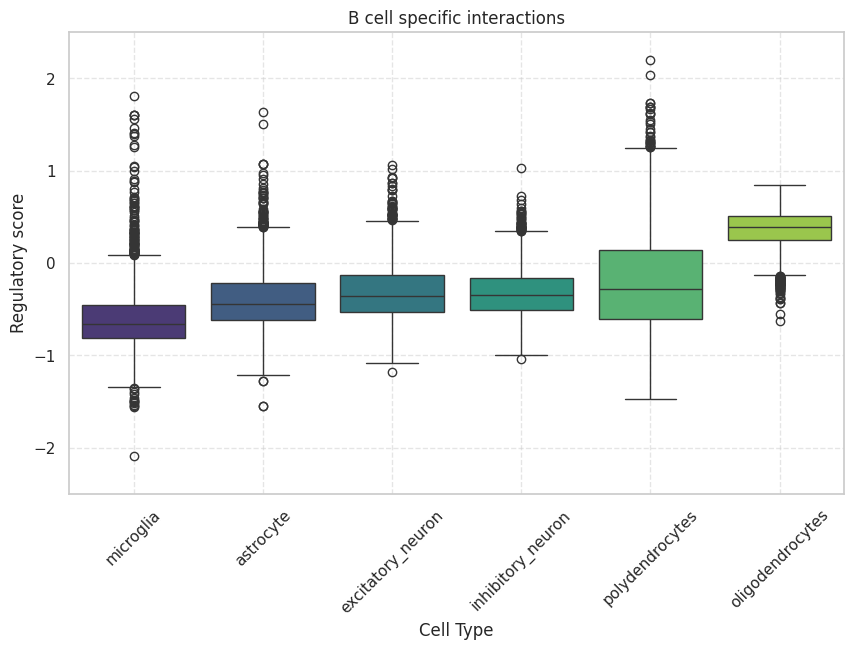

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# temp_normalized = cell_link_enhancer[:, edge_index].cpu().numpy() * cell_link_activity[:, edge_index].cpu().numpy()
temp_normalized = cell_link_edge[:, edge_index].cpu().numpy()
temp_normalized = zscore(temp_normalized, axis=0) 

# 计算每个细胞类型组的均值
means = [np.mean(temp_normalized[cell_type_cpu == unique_celltype[i], :], axis=0) for i in range(len(unique_celltype))]

# 创建数据框并按均值排序
mean_data = {'Group': ['Type ' + str(i) for i in range(len(unique_celltype))],
             'Mean': [np.median(m) for m in means]}
mean_df = pd.DataFrame(mean_data).sort_values(by='Mean')

# 准备用于绘图的数据
sorted_means = [means[int(group.split(' ')[1])] for group in mean_df['Group']]
data = {'Group': np.repeat(mean_df['Group'], [len(m) for m in sorted_means]),
        'Values': np.concatenate(sorted_means)}
df = pd.DataFrame(data)
mean_df['Group'] = [unique_celltype[int(group.split(' ')[1])] for group in mean_df['Group']]

# 用更新的 Group 名字来替换 data 中的 Group
df['Group'] = [unique_celltype[int(group.split(' ')[1])] for group in df['Group']]

sns.set(style="whitegrid") 
palette = sns.color_palette("viridis", len(unique_celltype))  

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Values', data=df, order=mean_df['Group'], palette=palette)
plt.title("B cell specific interactions")
plt.ylabel("Regulatory score")
plt.xlabel("Cell Type")
plt.ylim(-2.5, 2.5)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# plt.savefig('./fig/B_cell.png')
plt.show()

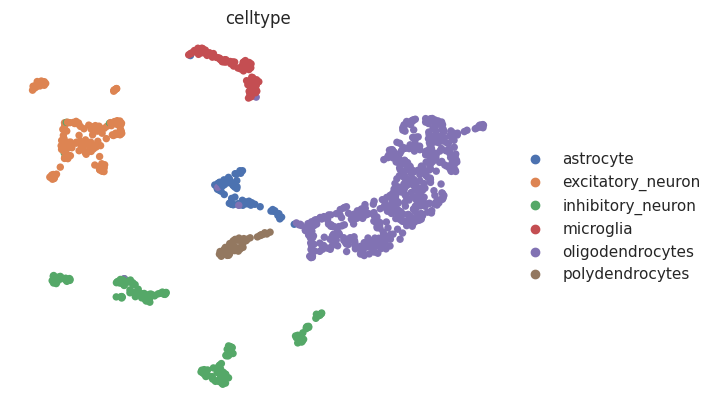

In [23]:
data_np = cell_link_edge.cpu().numpy() 
import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)